In [ ]:
# Install the statistical library
!pip install pmdarima

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score
import warnings

warnings.filterwarnings("ignore")

In [ ]:
print(" Loading Data...")
df = pd.read_csv('final_training_data_all_regions.csv')
df['time'] = pd.to_datetime(df['time'])

# Filter for Doha
data = df[df['region'] == 'doha'].copy()
data = data.set_index('time').sort_index()
data = data.asfreq('H').ffill()

# Define Target & Exogenous Variables (Weather)
target_col = 'pm2_5 (μg/m³)'
exog_cols = ['temperature_2m (°C)', 'relative_humidity_2m (%)', 'wind_speed_10m (km/h)']

target = data[target_col]
exog = data[exog_cols]

# Separate Last Week for Final Test
final_test_size = 168
train_val_target = target.iloc[:-final_test_size]
train_val_exog = exog.iloc[:-final_test_size]

final_test_target = target.iloc[-final_test_size:]
final_test_exog = exog.iloc[-final_test_size:]

print(f"Total History: {len(train_val_target)} hours")
print(f"Final Test Set: {len(final_test_target)} hours")


🚀 Loading Data...
Total History: 25488 hours
Final Test Set: 168 hours


In [ ]:
print("\n Finding best parameters (using last 2 weeks)...")
# We include X (exogenous) here so auto_arima knows we have weather data
model_auto = auto_arima(train_val_target.iloc[-336:],
                        X=train_val_exog.iloc[-336:],
                        seasonal=True, m=24,
                        start_p=0, start_q=0, max_p=2, max_q=2, d=None,
                        trace=False, error_action='ignore', suppress_warnings=True)

fixed_order = model_auto.order
fixed_seasonal_order = model_auto.seasonal_order
print(f" Parameters Locked: {fixed_order} x {fixed_seasonal_order}")



🔍 Finding best parameters (using last 2 weeks)...
✅ Parameters Locked: (1, 1, 0) x (2, 0, 0, 24)


In [ ]:
window_size = 4380  # 6 Months
test_size = 168     # 1 Week
step_size = 4380    # Move forward 6 months

results = []
current_start = 0

print(f"\n🔄 Starting Cross-Validation (6-Month Intervals)...")

def get_class_metrics(actual, predicted, threshold=35.0):
    y_true = (actual > threshold).astype(int)
    y_pred = (predicted > threshold).astype(int)
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0)
    }

while current_start + window_size + test_size < len(train_val_target):
    # Slice Target
    train_end = current_start + window_size
    test_end = train_end + test_size

    y_train_fold = train_val_target.iloc[current_start : train_end]
    y_test_fold = train_val_target.iloc[train_end : test_end]

    # Slice Exogenous (Weather)
    X_train_fold = train_val_exog.iloc[current_start : train_end]
    X_test_fold = train_val_exog.iloc[train_end : test_end]

    try:
        # Train SARIMAX with Weather Data (exog)
        model = SARIMAX(y_train_fold,
                        exog=X_train_fold,
                        order=fixed_order,
                        seasonal_order=fixed_seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        model_fit = model.fit(disp=False)

        # Forecast using Future Weather (X_test_fold)
        # This prevents the flat line!
        forecast = model_fit.get_forecast(steps=test_size, exog=X_test_fold)
        preds = forecast.predicted_mean

        # Metrics
        rmse = np.sqrt(mean_squared_error(y_test_fold, preds))
        mae = mean_absolute_error(y_test_fold, preds)
        class_metrics = get_class_metrics(y_test_fold, preds)

        print(f"   Fold {len(results)+1}: RMSE={rmse:.2f} | MAE={mae:.2f}")

        results.append({
            "Fold": len(results)+1,
            "Train_End": y_train_fold.index[-1].date(),
            "RMSE": rmse,
            "MAE": mae,  # Added back!
            **class_metrics
        })

    except Exception as e:
        print(f"    Error: {e}")

    current_start += step_size



🔄 Starting Cross-Validation (6-Month Intervals)...
   Fold 1: RMSE=22.07 | MAE=18.15
   Fold 2: RMSE=9.82 | MAE=8.27
   Fold 3: RMSE=22.11 | MAE=16.76
   Fold 4: RMSE=7.74 | MAE=6.46
   Fold 5: RMSE=47.39 | MAE=44.44


In [ ]:

print("\n FINAL EXAM: Testing on the Hidden Last Week...")

# Train on the most recent 6-month window
last_train_start = len(train_val_target) - window_size
final_y_train = train_val_target.iloc[last_train_start:]
final_X_train = train_val_exog.iloc[last_train_start:]

final_model = SARIMAX(final_y_train,
                      exog=final_X_train,
                      order=fixed_order,
                      seasonal_order=fixed_seasonal_order,
                      enforce_stationarity=False,
                      enforce_invertibility=False)
final_fit = final_model.fit(disp=False)

# Forecast using the hidden week's weather
final_forecast = final_fit.get_forecast(steps=len(final_test_target), exog=final_test_exog)
final_preds = final_forecast.predicted_mean
final_conf = final_forecast.conf_int()

# Final Metrics
final_rmse = np.sqrt(mean_squared_error(final_test_target, final_preds))
final_mae = mean_absolute_error(final_test_target, final_preds)
final_class = get_class_metrics(final_test_target, final_preds)

print(f"\n FINAL RESULTS (Unseen Data):")
print(f"RMSE: {final_rmse:.2f}")
print(f"MAE:  {final_mae:.2f}")
print(f"Accuracy: {final_class['Accuracy']:.2%}")


🏁 FINAL EXAM: Testing on the Hidden Last Week...

🏆 FINAL RESULTS (Unseen Data):
RMSE: 10.25
MAE:  8.20
Accuracy: 69.05%


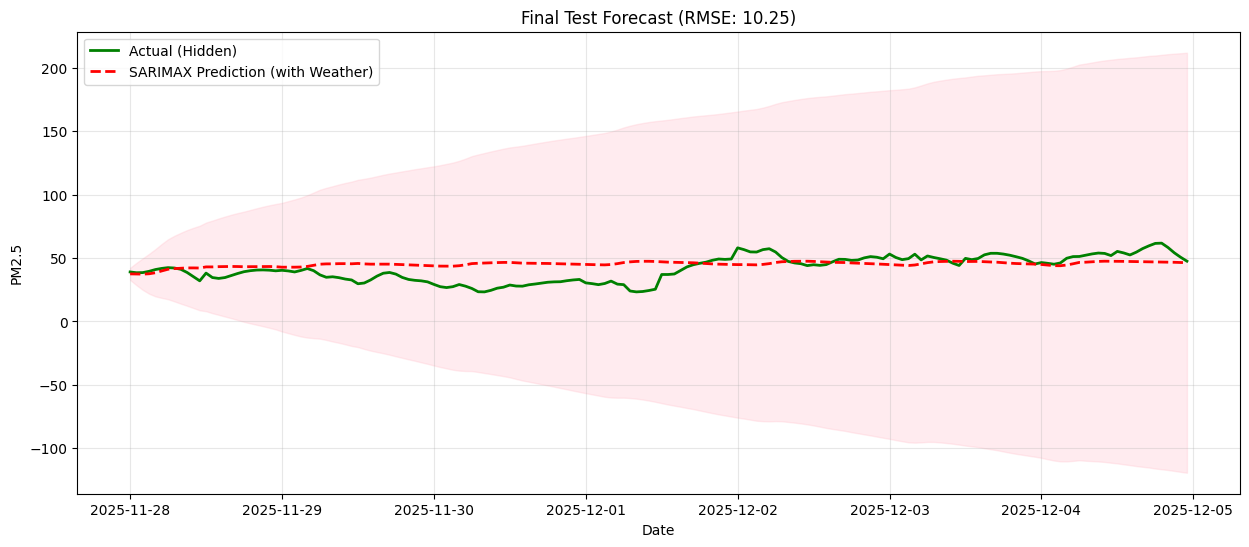


📊 Cross-Validation Summary:
 Fold      RMSE       MAE  Accuracy  Precision  Recall
    1 22.072266 18.150485  0.803571   0.803571 1.00000
    2  9.819410  8.269430  0.309524   0.144068 0.53125
    3 22.114303 16.755105  0.369048   0.000000 0.00000
    4  7.744873  6.460344  0.642857   0.250000 0.10000
    5 47.385806 44.435191  0.815476   0.815476 1.00000


In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(final_test_target.index, final_test_target, label='Actual (Hidden)', color='green', linewidth=2)
plt.plot(final_test_target.index, final_preds, label='SARIMAX Prediction (with Weather)', color='red', linestyle='--', linewidth=2)
plt.fill_between(final_test_target.index, final_conf.iloc[:,0], final_conf.iloc[:,1], color='pink', alpha=0.3)
plt.title(f"Final Test Forecast (RMSE: {final_rmse:.2f})")
plt.xlabel("Date")
plt.ylabel("PM2.5")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Show Full Summary including MAE
results_df = pd.DataFrame(results)
print("\n Cross-Validation Summary:")
print(results_df[['Fold', 'RMSE', 'MAE', 'Accuracy', 'Precision', 'Recall']].to_string(index=False))